# Exploration 8. 뉴스 요약봇 만들기
본 과제를 통해 뉴스 데이터셋에 대한 추상적, 추출적 요약 기법을 사용하여 뉴스 기사를 요약한다.

## 루브릭 평가 기준
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.<br>
   분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.<br>
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.<br>
   모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.<br>
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.<br>
   두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.<br>
   
* * *

## 패키지 로드 및 데이터 수집
* 아래 링크에 있는 뉴스 기사 데이터인(news_summary_more.csv)를 이용한다.<br>
[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

* * *

## [NLTK(Natural Language Toolkit)](https://datascienceschool.net/03%20machine%20learning/03.01.01%20NLTK%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html)
* 교육용으로 개발된 자연어 처리 및 문서 분석용 파이썬 패키지
* 다양한 기능 및 예제를 가지고 있으며 실무 및 연구에서도 많이 사용
* 주요 기능
  * 말뭉치
    * 자연어 분석 작업을 위해 만든 샘플 문서 집합
    * 단순히 소설, 신문 등의 문서를 모아놓은 것도 있지만 품사. 형태소, 등의 보조적 의미를 추가하고 쉬운 분석을 위해 구조적인 형태로 정리해 놓은 것을 포함
    * 설치시에 제공되지 않고 download 명령으로 사용자가 다운로드 받아야 함
  * 토큰 생성
    * 긴 문자열을 분석을 위하여 작은 단위로 분할하는 것
    * 토큰 생성(tokenizing) : 문자열을 토큰으로 나누는 작업
    * 토큰 생성 함수(tokenizer) : 문자열을 토큰으로 분리하는 함수
  * 형태소(morpheme) 분석
    * 형태소(morpheme) : 언어학에서 일정한 의미가 있는 가장 작은 말의 단위
    * 보통 자연어 처리에서는 토큰으로 형태소를 이용
    * 단어로부터 어근, 접두사, 접미사, 품사 등 다양한 언어적 속성을 파악하고 이를 이용하여 형태소를 찾아내거나 처리하는 작업이 형태소 분석
  * 품사(POS, part-of-speech) 태깅
    * 품사(POS, part-of-speech) : 낱말을 문법적인 기능이나 형태, 뜻에 따라 구분한 것

## [불용어(Stopword)](https://wikidocs.net/22530)
* 갖고 있는 데이터에서 유의미한 단어 토큰만을 선별하기 위해서는 큰 의미가 없는 단어 토큰을 제거하는 작업이 필요
* 큰 의미가 없다는 것은 자주 등장하지만 분석에서는 큰 도움이 되지 않은 단어들을 말하는데, 이러한 단어들을 불용어라고 함<br>
  ex) I, my, me, over, 조사, 접미사 같은 단어들은 문장에서는 자주 등장하지만 실제 의미 분석을 하는데는 거의 기여하는 바가 없음
* NLTK에서는 위와 같은 100여개 이상의 영어 단어들을 불용어로 패키지 내에서 미리 정의하고 있음
* 개발자가 불용어를 직접 정의할 수도 있음

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
85109,Door to remain in EU is open to Britain: Frenc...,At a joint news conference with British PM The...
73296,Islamic State releases video threatening the Pope,ISIS has released a new propaganda video showi...
5538,"Nobody approached Sara for Simmba, she approac...",Filmmaker Rohit Shetty has said Sara Ali Khan ...
17121,"21,000 Telangana voters aged between 100 and 2...",Congress has alleged the voters' list released...
83849,Remark on daughter Jhanvi's marriage misunders...,Sridevi has said that her earlier statement ab...
5263,SoftBank Vision Fund to invest over $1 bn in G...,Masayoshi Son-led Japanese conglomerate SoftBa...
20618,80 people held for protesting near Samsung pla...,At least 80 people were arrested on Tuesday fo...
24549,"Release date of Amitabh, Taapsee starrer 'Badl...",The release date of Amitabh Bachchan and Taaps...
46311,Actress Sridevi passes away after cardiac arrest,Veteran Bollywood actress Sridevi passed away ...
81011,World's 1st laptop with wireless charging laun...,American technology company Dell has launched ...


* 이 데이터는 기사의 본문에 해당하는 text와 headlines 두 가지 열로 구성되어 있다.
* 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다.
* 추출적 요약을 하는 경우에는 오직 text 열만을 사용한다.

In [5]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [6]:
print('전체 샘플수 : ', (len(data)))

전체 샘플수 :  98401


* * *

## 데이터 전처리하기(추상적 요약)
* 어떤 전처리가 필요한지 선택하고, 선택한 전처리를 추가 사용하여 텍스트를 정규화 또는 정제한다.
* 불용어 제거를 선택할 경우, 상대적으로 길이가 짧은 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민 해 본다.

* * *

## 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [7]:
# 데이터의 중복 샘플 유무 확인

print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [8]:
# 데이터프레임의 drop_duplicates()를 사용하여 중복 샘플을 제거 
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 변경
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
# 데이터프레임에 Null 값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## [텍스트 정규화(Text Normalization)와 불용어 제거](https://wikidocs.net/21693)
* 정제 및 정규화의 목적 : 
  * 정제(cleaning) : 갖고 있는 말뭉치로부터 노이즈 데이터를 제거
  * 정규화(normalization) : 표현 방법이 다른 단어들을 통합시켜서 같은 단어로 만들어 줌
* 정제 작업은 토큰화 작업에 방해가 되는 부분들을 배제시키고 토큰화 작업을 수행하기 위해서 토큰화 작업보다 앞서 이루어지기도 하지만, 토큰화 작업 이후에도 여전히 남아있는 노이즈들을 제거하기 위해 지속적으로 이루어지기도 함

In [10]:
# 텍스트 정규화를 위한 사전(dictionary) 구성
# 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# NLTK에서 제공하는 불용어 리스트 참조
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 위의 불용어 리스트를 이용하여, 샘플에서 불용어를 제거
# 뿐만 아니라 모든 영어 문자는 소문자로 만들고, 섞여 있는 html 태그를 제거함
# 정규 표현식을 통해 각종 특수문자를 제거

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [13]:
# 전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않음

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [14]:
# 훈련 데이터 전체에 대한 전처리 수행
# text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행

clean_text = []
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# text 전처리 후 결과 확인을 위해 상위 5개의 줄 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [15]:
clean_summary = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))
    # 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 삽입

print("headlines 전처리 후 결과: ", clean_summary[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [16]:
# 텍스트 정제의 과정을 거친 후, 다시 한번 빈(empty) 샘플이 생겼는지 확인
# 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있기 때문
# 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체하여 데이터들을 데이터프레임에 저장

data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [17]:
# null값 존재여부 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

* * *

## 훈련 데이터와 테스트 데이터 나누기

* 훈련에 사용할 샘플의 최대 길이 결정
* Text와 Summary의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


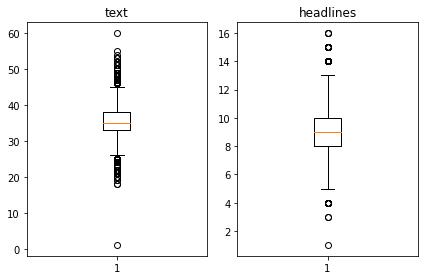

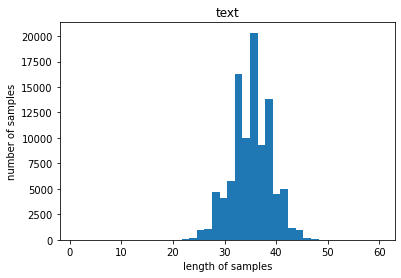

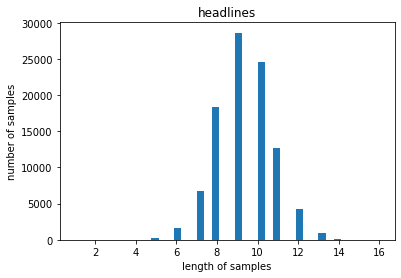

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

각 그래프가 가지는 의미는 다음과 같다 : 
1. 실제 텍스트와 요약의 길이 분포
2. 실제 텍스트 샘플 길이별 개수
3. 요약본 샘플 길이별 개수

In [19]:
# text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 지정

text_max_len = 60
summary_max_len = 10
print('=3')

=3


In [20]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만든다.

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [21]:
# 직접 결정한 임의의 길이가 몇 %의 샘플까지 포함하는지 확인

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


각각 60과 10으로 padding을 주었을 때 해당 길이보다 긴 샘플들은 내용이 잘리게 된다. headlines 열의 경우 약 20%의 샘플들의 내용이 손상될 것이라고 예상 가능하다. 따라서 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제하도록 한다.

In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 80291


* * *

## 어텐션 메커니즘을 사용한 seq2seq 사용하기 (추상적 요약)
* [시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq)](https://wikidocs.net/24996)
  * 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 다양한 분야에서 사용되는 모델<br>
    ex) 입력 시퀀스와 출력 시퀀스를 각각 질문과 대답으로 구성하면 챗봇으로 만들 수 있고, 입력 시퀀스와 출력 시퀀스를 각각 입력 문장과 번역 문장으로 만들면 번역기로 만들 수 있음<br>
  * 크게 인코더와 디코더라는 두 개의 모듈로 구성<br>
    <img src="https://wikidocs.net/images/page/24996/seq2seq%EB%AA%A8%EB%8D%B811.PNG"><br>
    * 인코더는 입력 문장의 모든 단어들을 순차적으로 입력받은 뒤에 마지막에 이 모든 단어 정보들을 압축해서 하나의 벡터로 만드는데 이를 컨텍스트 벡터(context vector)라고 함<br>
    * 입력 문장의 정보가 하나의 컨텍스트 벡터로 모두 압축되면 인코더는 컨텍스트 벡터를 디코더로 전송<br>
    * 디코더는 컨텍스트 벡터를 받아서 번역된 단어를 한 개씩 순차적으로 출력<br>
    
* * *

## 시작 토큰과 종료 토큰 추가하기
* 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 중단함
* seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있음
* 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가
* 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름 : decoder_input
* 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름 : decoder_target

In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [24]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [25]:
# 훈련 데이터와 테스트 데이터 분리
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[47592 62103 73593 ... 69710 55515 62120]


In [26]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [27]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 16058


In [28]:
# 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분
# : 표시의 위치에 주의

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 64233
훈련 레이블의 개수 : 64233
테스트 데이터의 개수 : 16058
테스트 레이블의 개수 : 16058


## 단어 집합(vocabulary) 만들기 및 정수 인코딩
* 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 변경하여야 함
* 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요하며, 이를 단어 집합(vocabulary) 을 만든다고 표현
* Keras의 토크나이저를 이용하여 훈련 데이터에 대한 단어 집합 생성

In [29]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


* 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여됨
* 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있는 상태
* 그러나 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들을 훈련 데이터에서 제외하고 진행

In [30]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
# src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어 있으며, 
# 이를 통해서 통계적인 정보 확인이 가능함

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64952
등장 빈도가 6번 이하인 희귀 단어의 수: 44610
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20342
단어 집합에서 희귀 단어의 비율: 68.68148786796404
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.006241031505786


In [31]:
# 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
# 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기를 20,000으로 제한

src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [32]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
# 현재 단어 집합의 크기를 20,000으로 제한했으므로, 20,000이 넘는 숫자들은 정수 인코딩 후 데이터에 존재하지 않음

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4131, 10, 406, 11314, 12456, 585, 10102, 4713, 5196, 472, 175, 13, 8293, 1800, 150, 4668, 1377, 2191, 7452, 4131, 13, 18981, 10672, 23, 1377, 3172, 4469, 14567, 7581, 829, 2685, 4378, 13951, 9615, 13952], [1161, 7, 51, 351, 20, 4470, 281, 3519, 321, 25, 198, 9, 73, 2365, 20, 9616, 78, 228, 81, 9616, 1658, 1161, 1690, 14, 2289, 18982, 1, 2269, 9389, 1065, 4], [5, 622, 435, 18983, 8294, 1846, 27, 124, 797, 802, 992, 2761, 2534, 1781, 261, 16, 1239, 3333, 8000, 5, 16, 119, 39, 33, 1524, 552, 16, 1356, 2534, 4, 802, 224, 726, 106, 1760, 180, 992]]


In [33]:
# headlines 데이터에 대해서도 동일한 작업을 수행

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [34]:
# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어 있음
# 등장 빈도수가 6회 미만인 단어들이 차지하는 비중을 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28435
등장 빈도가 5번 이하인 희귀 단어의 수: 18971
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9464
단어 집합에서 희귀 단어의 비율: 66.71707402848602
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.717729379920714


In [35]:
# 어림잡아 9,000을 단어 집합의 크기로 제한

tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 37, 298, 12, 8592, 2161, 286, 5714, 694, 66], [1, 62, 2254, 7, 525, 6043, 325, 28, 63, 58], [1, 103, 7, 484, 39, 10, 2027, 3923, 14, 1517], [1, 63, 5, 3353, 576, 614, 3, 254], [1, 27, 5412, 4346, 106, 242, 5132, 470, 21, 42, 461]]
target
decoder  [[37, 298, 12, 8592, 2161, 286, 5714, 694, 66, 2], [62, 2254, 7, 525, 6043, 325, 28, 63, 58, 2], [103, 7, 484, 39, 10, 2027, 3923, 14, 1517, 2], [63, 5, 3353, 576, 614, 3, 254, 2], [27, 5412, 4346, 106, 242, 5132, 470, 21, 42, 461, 2]]


decoder_input_train과 decoder_target_train에는 더 이상 숫자 9,000이 넘는 숫자들은 존재하지 않아 정상적으로 정수 인코딩 작업이 끝난 것을 확인할 수 있다. 그러나 패딩 단계에서 확인해야 할 부분이 있는데, 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈 샘플이 되었을 가능성이 있음을 의미한다. 따라서 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아 온 뒤, 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해서 모두 삭제하도록 한다.

In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 64233
훈련 레이블의 개수 : 64233
테스트 데이터의 개수 : 16058
테스트 레이블의 개수 : 16058


## 패딩하기
* 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰 주는 패딩 작업이 필요
* 전 단계에서 정해둔 최대 길이로 패딩
* 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 삽입해 최대 길이로 길이를 맞춤

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


## 모델 설계하기
먼저, 함수형 API를 이용해서 인코더를 설계한다.

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

* 임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의
* hidden state
  * LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터
  * LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수에 해당
* 인코더의 LSTM
  * 총 3개의 층으로 구성해서 모델의 복잡도를 높임
  * hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘림
  * 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 전송
  * dropout 뿐 아니라 recurrent dropout까지 사용
* [dropout](https://modulabs.notion.site/7-3-5afa05876d8848608b4da53a732d683f)
  <img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fm5YtD%2FbtrbwgszFXZ%2FxdUhkeyK2lmrQXYy7HioL0%2Fimg.png"><br>
  * 서로 연결된 연결망(layer)에서 0과 1 사이의 확률로 뉴런을 제거(drop)하는 기법<br>
  * Drop-out Rate는 하이퍼파라미터이며, 0.5로 설정하는 것이 일반적<br>
  * 특정한 데이터셋만을 과도하게 집중 학습함으로써 발생할 수 있는 과적합(Overfitting)을 방지하기 위해 사용됨<br>
* recurrent dropout<br>
  * 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결<br>
  * recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식으로, time step의 입력을 랜덤으로 생략<br>
  * 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지<br>
  * recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸리기 때문에, 아래와 같은 경고문이 출력됨<br>
    WARNING:tensorflow:Layer lstm_5 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


In [40]:
# 디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다.
# 다만 차이점은, LSTM의 입력을 정의할 때 initial_state의 인자값으로 인코더의 hidden state와 cell state의 값의 삽입이 필요하다.

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
# headlines의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 함
# 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있음
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 


# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 128)      2560000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 60, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## [어텐션 메커니즘 (Attention Mechanism)](https://wikidocs.net/22893)
* RNN에 기반한 seq2seq 모델이 가지는 문제점
  1. 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하다 보니 정보 손실이 발생
  2. RNN의 고질적인 문제인 기울기 소실(vanishing gradient) 문제가 존재
* 이로 인해 기계 번역 분야에서는, 입력 문장이 길면 번역 품질이 떨어지는 현상이 발생하게 됨
* 이 문제를 해결하기 위해 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정 해 주는 어텐션(attention) 기법이 등장
* 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고하는 것이 기본 아이디어
* 단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아닌, 해당 시점에서 예측해야 할 단어와 연관이 있는 입력 단어 부분에 좀 더 집중(attention)

In [41]:
# 어텐션 층을 생성하고, 위에서 설계한 디코더의 출력층 수정

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 128)      2560000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 60, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다.

* * *

## 모델 훈련하기
* 설계된 모델을 이용하여 훈련을 진행한다.

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 조기 종료(EarlyStopping)
# val_loss(검증 데이터의 손실)을 관찰하다가, 
# 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정
# 즉, EarlyStopping이 작동하게 되면 아무리 epoch의 값이 크더라도 모델 훈련을 최적점에서 중단할 수 있음
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
251/251 [==============================] - 207s 789ms/step - loss: 6.2680 - val_loss: 5.8372
Epoch 2/50
251/251 [==============================] - 196s 779ms/step - loss: 5.7016 - val_loss: 5.4727
Epoch 3/50
251/251 [==============================] - 195s 777ms/step - loss: 5.3638 - val_loss: 5.2400
Epoch 4/50
251/251 [==============================] - 194s 771ms/step - loss: 5.0713 - val_loss: 4.9830
Epoch 5/50
251/251 [==============================] - 194s 772ms/step - loss: 4.8313 - val_loss: 4.8178
Epoch 6/50
251/251 [==============================] - 192s 766ms/step - loss: 4.6361 - val_loss: 4.6822
Epoch 7/50
251/251 [==============================] - 193s 768ms/step - loss: 4.4672 - val_loss: 4.5871
Epoch 8/50
251/251 [==============================] - 194s 774ms/step - loss: 4.3214 - val_loss: 4.5055
Epoch 9/50
251/251 [==============================] - 193s 768ms/step - loss: 4.1911 - val_loss: 4.4394
Epoch 10/50
251/251 [==============================] - 193s 767m

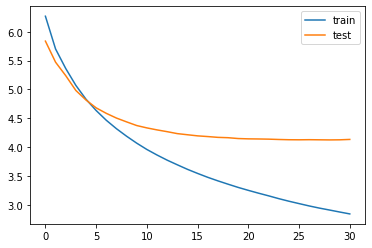

In [43]:
# 훈련 데이터와 검증 데이터의 손실이 감소하는 과정 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기
* 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원하는 작업이 필요
* 아래 코드와 같이 필요한 3개의 사전을 준비

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


* 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있기 때문에, 둘을 하나로 묶은 모델을 설계함
* 반면 정답 문장이 없는 인퍼런스 단계에서는 생성할 문장의 길이만큼 디코더가 반복적으로 동작하기 때문에 별도의 모델 설계가 필요
* 이때, 인코더와 디코더 모델을 분리해서 설계

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [46]:
# 어텐션 메커니즘을 사용하는 출력층 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [47]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 생성

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## 모델 테스트하기
* 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 생성
  * text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외
  * headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


* * *

## 실제 결과와 요약문 비교하기(추상적 요약)

In [49]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : talking sara ali khan making bollywood debut upcoming film kedarnath producer ronnie said sara absolute star told director abhishek kapoor came watch minutes film look like sara first film seemed like fifth film added ronnie 
실제 요약 : sara ali khan is star kedarnath producer 
예측 요약 :  saif ali khan debut film saif


원문 : year old female trainee pilot india among three people killed mid air collision two training aircraft flight school florida us nisha reportedly enrolled dean international flight school september notably flight school involved total incidents since 
실제 요약 : indian among those killed in aircraft collision in us 
예측 요약 :  indian pilot killed in flight for trying to enter


원문 : congress leader shashi tharoor wednesday pointed typo made tweet apologised people looked misspelt word dictionary tharoor misspelt tweet tuesday bet many would considered nominating word year person commented tharoor apology 
실제 요약 : tharoor makes apologises to people it in dictionary 
예측 요약 

* * *

## Summa을 이용해서 추출적 요약해보기
* 추상적 요약의 경우 다양한 문장의 표현력이 가능하지만, 추출적 요약에 비해 난이도가 높음
* 반면 추출적 요약은 기존의 문장에서 문장을 꺼내오는 형태이기 때문에 요약의 정확도가 추상적 요약에 비해 높음

In [50]:
import requests
from summa.summarizer import summarize

# 매트릭스 시놉시스 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [51]:
# 매트릭스 시놉시스가 문자열로 저장된 text의 일부분을 출력
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

## summarize 사용하기
* Summa의 summarize()의 인자로 사용되는 값들은 아래와 같다 : 
  * text (str) : 요약할 텍스트
  * ratio (float, optional) : 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
  * words (int or None, optional) : 출력에 포함할 단어 수
    만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시
  * split (bool, optional) : True면 문장 list / False는 조인(join)된 문자열을 반환
* Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행하기 때문에, 문장 구분이 되어 있지 않은 원문을 바로 입력할 수 있음

In [53]:
# 요약문으로 선택되는 문장의 개수를 줄임
# 원문의 0.005%만을 출력하도록 설정
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [54]:
# 출력 결과를 리스트 형태로 얻기를 원할 경우, split 인자의 값을 True로 지정
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [55]:
# 단어의 수로 요약문의 크기 조절
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


* * *

## 마치며
* 본 과제는 영문 데이터셋으로 진행하였지만, 네이버 뉴스의 요약봇처럼 한국어 데이터셋으로도 이번에 배운 방식을 시도 해 보고 싶다.
* 추상적 요약 기법을 수행했을 경우 원래 내용과 관련이 없는 엉뚱한 결과물이 여러 개 출력되는 경우가 발생하는데, 이러한 오류를 줄이는 방법에 대한 연구가 추가적으로 필요하다고 느꼈다. 장기 의존성(long term dependencies) 문제를 줄이기 위한 어텐션 매커니즘이 등장했지만 성능적인 면에서 여전히 개선이 필요하다고 생각한다.
* 따라서 아래와 같은 성능 개선 기법에 대해 추가적으로 학습 및 조사가 필요하다 : 
  * seq2seq와 어텐션의 조합을 좀 더 적합한 방향으로 수정하는 방법
  * 빔 서치(beam search)
  * 사전 훈련된 워드 임베딩(pre-trained word embedding)
  * 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)